In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', str)

In [3]:
def simulate_garch(initial_value, drift, backfill, num_steps, delta_t):
    '''
    initial_value = float, drift = float, volatility = float, num_steps = int, delta_t = int
    drift is the draft rate (mu), backfill includes GARCH params (omega, alpha, beta) with (initial return and conditional vol)
    num_steps is the required time steps for simulation (t = T). delta_t is the time increment (dt)
    '''
    # initializing a array for storying stock price path with size == steps, initialize all value to zero
    prices = np.zeros(num_steps)
    prices[0] = initial_value

    # GARCH parameters and backfilled data
    omega, alpha, beta, initial_return, initial_sigma = backfill

    # initialize r(t-1) and sigma(t-1)
    return_t_lag = initial_return 
    sigma_t_lag = initial_sigma 
    
    # Rt with GARCH formula
    for i in range(1, num_steps):
        epsilon = np.random.normal(0, 1)  # Generate a random number from a standard normal distribution
        drift_component = drift * delta_t  # Drift component of the price change (mu * dt) (correct)

        # TODO: find a way to pass omgea, alpha, beta value (params)
        # TODO: find a way to store r(t-1) and sigma(t-1)
        sigma_t_sq = omega + alpha * return_t_lag ** 2 + beta * sigma_t_lag**2 
        sigma_t = sigma_t_sq ** 0.5
        volatility_component = sigma_t * epsilon 
        # Volatility component of the price change (sigma_t * epsilon, where epsilon N(0,1), sigma_t is from garch formula)
        rateof_price_change = drift_component + volatility_component  # r(t)
        # Finally: Update the price with price change
        prices[i] = prices[i-1] * (1 + rateof_price_change)  
        # note that simple return is used in GARCH implementation, so (1+rt) instead of exp(rt)

        # after finishing calculation, update return and sigma lag 1
        return_t_lag, sigma_t_lag = rateof_price_change, sigma_t

    return prices

In [4]:
# Plotting Multi Path
def multiPathSim(path, num_steps):
    '''
    Path: int, specify a number of path for simulation
    return type: paths stored
    '''
    # Simulate GARCH paths
    paths = np.zeros((path, num_steps))
    for i in range(num_paths):
        paths[i] = simulate_gbm(initial_value, drift, volatility, num_steps, delta_t)
    return paths

In [5]:
snp = pd.read_csv("data/SPXall.csv")

In [6]:
snp = snp[['Date', 'Close']]
snp

,Date,Close
0,1927-12-30,17.66
1,1928-01-03,17.76
2,1928-01-04,17.719999
3,1928-01-05,17.549999
4,1928-01-06,17.66
...,...,...
24220,2024-06-03,5283.399902
24221,2024-06-04,5291.339844
24222,2024-06-05,5354.029785
24223,2024-06-06,5352.959961


In [7]:
def dataInRequiredTimeFrame(data, start = "1999-06-01" , end = "2024-06-01", datecol = "Date"):
    '''data: pd.DataFrame, storing the required data to be sliced for timeframe
    start: string, start date required
    end: string, end date required 
    datecol: string, what is the column name that store the Date in the data
    return: sliced pd.DataFrame, the sliced data is returned, inclusive of start and end date data
    '''
    # convert string to datetime object
    start_date, end_date = pd.to_datetime(start), pd.to_datetime(end)
    data[datecol] = pd.to_datetime(data[datecol])
    # filter dataFrame within timeframe
    timefilter = (data[datecol] >= start_date) & (data[datecol] <= end_date)
    data = data[timefilter].reset_index(drop = True)
    # return the sliced dataFrame
    return data

In [8]:
start_date, end_date = "1999-06-01", "2024-06-01"
snp = dataInRequiredTimeFrame(data = snp, start = start_date , end = end_date)

In [9]:
# In the Journal of Forecasting paper (page 8), the mean daily return (mu) of SPX is neglected
# Therefore we set mu as 0 in the following
mu = 0



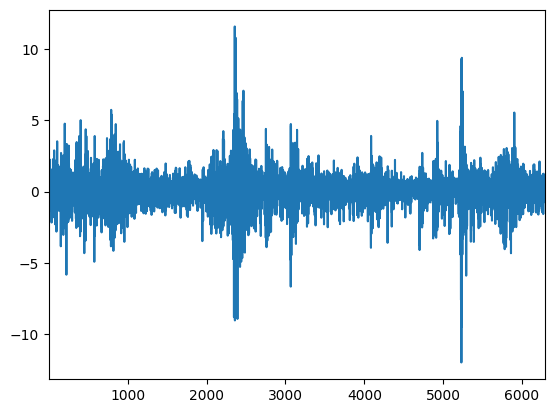

In [10]:
returns = 100 * snp["Close"].pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

In [11]:
# GARCH model
from arch import arch_model

# GARCH Model Fitted with Zero Mean 
# (paper p.7: daily mean return is neglected since its value is too small (empircally 0.06% here)
p, q = 1, 1
am = arch_model(returns, mean = 'Zero', vol='Garch', p=p, q=q)

res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     27,   Neg. LLF: 8923.12523777466
Iteration:     10,   Func. Count:     48,   Neg. LLF: 8718.796829637824
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8718.796829637824
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8718.80
Distribution:                  Normal   AIC:                           17443.6
Method:            Maximum Likelihood   BIC:                           17463.8
                                        No. Observations:                 6291
Date:                Tue, Jun 11 2024   Df Residuals:                     6291
Time:           

Text(0.5, 0, 'Year')

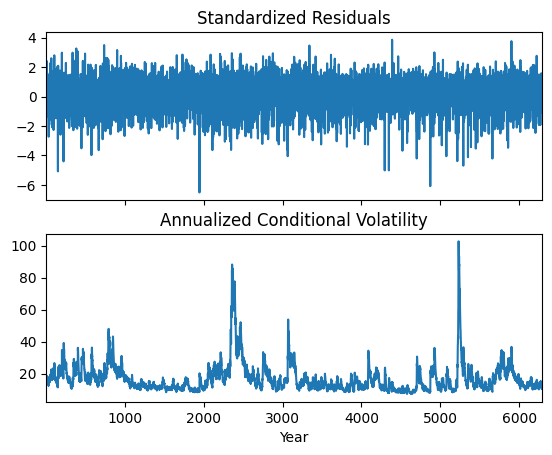

In [12]:
fig = res.plot(annualize="D")
plt.xlabel("Year")


In [13]:
omega, alpha, beta = res.params # get the parameters of GARCH
# Notes: due to returns scaling (*100), omega value has to be rescaled (by 10^-4)
omega /= 10**4

In [14]:
omega

2.122303770936074e-06

In [15]:
res.conditional_volatility

1      1.0066651428244795
2      0.9517345672723931
3      0.9091867152559827
4       1.126476448632339
5      1.0759536633417894
              ...        
6287   0.6787793235815833
6288   0.6914187274222321
6289   0.6621902030346013
6290   0.6815570212843721
6291   0.6829984208756384
Name: cond_vol, Length: 6291, dtype: float64

In [16]:
# Backfilling GARCH Params for simulation

# Notes: garch result index start from 1
# initial sigma(t-1)
initial_conditional_vol = res.conditional_volatility[1] / 100
# initial r(t-1)
initial_return = snp[0:2]["Close"].pct_change()[1]
print(initial_return, initial_conditional_vol)

0.0004249911113300975 0.010066651428244795


In [17]:
backfill = [omega, alpha, beta, initial_return, initial_conditional_vol]
# omega, a, b, r(t-1), sigma(t-1)
backfill

[2.122303770936074e-06,
 0.11169531289605478,
 0.8727017746532117,
 0.0004249911113300975,
 0.010066651428244795]

In [18]:
long_run_var_d = omega/(1-alpha-beta) # long run variance daily
long_run_var_y = 250 * long_run_var_d # long run variance yearly
long_run_sd_y = np.sqrt(long_run_var_y) # sd yearly (in decimal form) 
print("The long run variance yearly implied by GARCH model is", long_run_sd_y * 100, "%")

The long run variance yearly implied by GARCH model is 18.44042564882312 %


In [19]:
# Parameters (Base Parameters)

# TODO: Change to S&P parameters (initial_value = S&P value at start date, mu -> data; sigma -> GARCH, steps: change to len between start and end)
initial_value = snp[snp["Date"] == start_date]['Close'][0]
drift = 0 # Drift (mu) = 0

volatility = long_run_sd_y  # Volatility (standard deviation of returns)
num_steps = len(snp)  # Number of time steps (in days)
delta_t = 1/252  # Length of time interval (e.g., 1 trading day)
num_paths = 3  # Number of paths to simulate

# TODO: implement GARCH volatility in simulation

# Simulate GARCH paths
paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    paths[i] = simulate_garch(initial_value, drift, backfill, num_steps, delta_t)
#paths = multiPathSim(num_paths, num_steps)


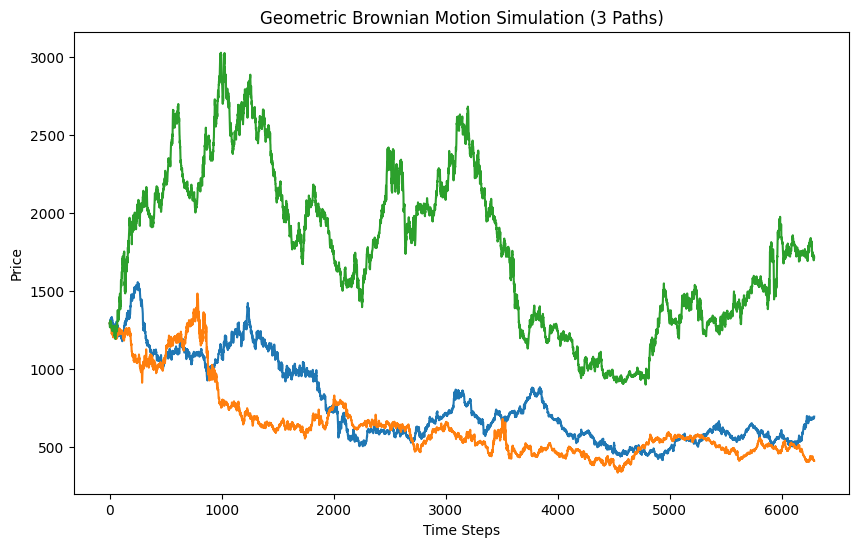

In [20]:
# Plot the simulated price paths
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(paths[i])
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title(f"Geometric Brownian Motion Simulation ({num_paths} Paths)")
plt.show()